## PPI General Linear Model

Here, PPI network construction is performed by evaluating multiple linear models and extracting regressors beta weights. PPI linear model takes form: 

$$y=\beta_0
+\beta_1\cdot x_{physio}
+\beta_2\cdot x_{out\_ons}
+\beta_3\cdot x_{out\_perr}
+\beta_4\cdot x_{PPI:out\_ons}
+\beta_5\cdot x_{PPI:out\_perr}
+\beta_6\cdot x_{dec\_ons}
+\beta_7\cdot x_{dec\_miss}
+\beta_8\cdot x_{dec\_wcor}
+\beta_9\cdot x_{res\_lbp}
+\beta_{10}\cdot x_{res\_rbp}
+\beta_{11}\cdot x_{res\_miss}
+\beta_{12}\cdot x_{out\_off}$$

Detailed regressors description:

| Regressor | Type | Description | Event Duration
|:--:|----|----|----|
| `y` | physiological | BOLD signal from target region | – |
| | | | |
| `physio` | physiological | BOLD signal from seed region | – |
| `out_ons` | psychological | outcome phase onset | 0.5s |
| `out_perr` | psychological | outcome phase onset parametrically modulated with prediction error | 0.5s |
| `ppi_out_ons` | interaction | `out_ons` point-by-point multiplied with <br />deconvolved seed timeseries, reconvolved with HRF | 0.5s 
| **`ppi_out_perr`** | interaction | `out_perr` point-by-point multiplied with <br />deconvolved seed timeseries, reconvolved with HRF | 0.5s |
| `dec_ons` | psychological | decision phase onset | 0.5s |
| `dec_miss` | psychological | decision phase onset for trials with missing response | 0.5s |
| `dec_wcor` | psychological | decision phase onset parametrically modulated with expected probability of being correct | 0.5s |
| `res_lbp` | psychological | left button press onset | 0.5s |
| `res_rbp` | psychological | right button press onset | 0.5s |
| `res_miss` | psychological | onset of isi phase for trials with missing response | 0.5s |
| `out_off` | psychological | outcome phase offset | 0.5s |
| `intercept` | other | intercept for linear model | – |

Each type of regressor was calculated differently: 
- **physiological regressors**: BOLD signals extracted using `NiftiSpheresMasker`. Before extraction confounds (24 head motion parameters, CSF and WM signals, squares, temporal derivatives and squares of temporal derivatives) and low-frequency drift were removed and signal was high pass-filtered (128s), 
- **psychological regressors**: task events convolved with canonical HRF using `compute_regressor` function from `nistats.hemodynamic_models` wrapped in custom `Regressor` class for consistent treating standard and parametrically modulated regressor, 
- **interaction (PPI) regressors**: first, ROIs timeseries were extracted with detrending and high-pass filtering. Then they were deconvolved using spm fuction for parameter estimation Bayes `spm_PEB.m`. Deconvolved and upsampled (by default 16 times) ROI timeseries were point-by-point multiplied with upsampled and demeaned task events timeseries to create interaction regressor in neural space. Finally, these interaction regressors were reconvolved with HRF and downsampled to create PPI regressors in BOLD space.

---
**Last update**: 31.08.2020

In [1]:
from IPython.display import clear_output
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as sm
import pandas as pd
import numpy as np
import sys
import os

from bids import BIDSLayout
from scipy import io
from scipy.stats import zscore

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.glm_utils import (convolve, Regressor, 
                                my_make_first_level_design_matrix)

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
# Directory for PPI analysis
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_betamats = os.path.join(path_out, 'betamats')
path_timeries = os.path.join(path_out, 'timeseries')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# Load trial modulations
path_modulations = os.path.join(path_nistats, 'modulations')
modulations_wcor = np.load(os.path.join(path_modulations, 'modulations_wcor.npy'))
modulations_perr = np.load(os.path.join(path_modulations, 'modulations_perr.npy'))

# Load neural & BOLD timeseries
data = io.loadmat(os.path.join(
    path_timeries, 
    'timeseries_pipeline-24HMPCSFWM_atlas-customROI_neural.mat'))
timeseries_neural_aggregated = data['timeseries_neural_aggregated']
timeseries_denoised_aggregated = np.load(os.path.join(
    path_timeries, 
    'timeseries_pipeline-24HMPCSFWM_atlas-customROI_bold.npy'))
downsamples = data['k'].flatten()

# Create directory for output
atlas_name = 'customROI'
path_results = os.path.join(path_betamats, atlas_name)
Path(path_results).mkdir(exist_ok=True)

# Acquisition parameters
_, _, n_volumes, n_rois = timeseries_denoised_aggregated.shape
t_r = 2

# Duration of phases
t_dec, t_out = 1.5, 1.5

#### Create design matrix

In [3]:
def upsampled_events(t_r, n_volumes, onset, duration, modulation=None, 
                     sampling_rate=1/16):
    '''Create upsampled regressors from given events.
    
    This function is used to create upsampled psychological regressors. These 
    can be used to create interaction regressors in PPI analysis. Since 
    deconvolved neural signal is usually upsampled (sixteen times by default is 
    SPM) and interaction regressors have to be created in the neural domain, 
    psychological regressor has to be upsampled to match sample rate for the
    neural regressor. Then PPI regressor can be calculated as point-by-point 
    multiplication of psychological and physiological regressors.
    
    Args:
        t_r (float):
            Scanning repetition time (TR).
        n_volumes (int):
            Number of scans for entire task.
        onset (iterable):
            Contains all event onset (in seconds).
        duration (float):
            Duration of event. Here, we assume all events have same duration.
        modulation (iterable, optional):
            Events amplitude modulation.
        sampling_rate (float):
            Upsampling rate. For 16-fold upsampling sampling_rate is 1/16.
            
    Returns:
        Numpy 1D array of length n_volumes / sampling_rate. Note that this 
        function returns demeaned psychological regressor (omitting demeaning 
        can produce spurious PPI effects if deconvolution is imperfect).
    '''
    if modulation is None:
        modulation = np.ones((len(onset), ))
    
    n_frames_per_event = int(duration / (t_r * sampling_rate))
    frame_times_up = np.arange(0, n_volumes*t_r, t_r*sampling_rate)
    ts_event_up = np.zeros(frame_times_up.shape)

    for event, amplitude in zip(onset, modulation):
        first_frame = np.argmax(frame_times_up >= event)
        ts_event_up[range(first_frame, 
                          first_frame + n_frames_per_event)] = amplitude
        
    return ts_event_up - ts_event_up.mean()

In [4]:
frame_times = np.arange(n_volumes) * t_r
sampling_rate = 1/16
event_duration = 1
beta_names = ['physio', 'dec_ons', 'dec_wcor', 'res_lbp', 'res_rbp', 
              'ppi_out_ons', 'ppi_out_perr', 'out_ons', 'out_perr', 'out_off',
              'reg_intercept']
n_regressors = len(beta_names)

for sub, sub_name in enumerate(meta['dim1']):
    for con, con_name in enumerate(meta['dim2']):

        beta_mats = np.zeros((n_regressors, n_rois, n_rois))

        # Extract task events
        resp_type = beh[sub, con, :, meta['dim4'].index('response')]
        onset_out = beh[sub, con, :, meta['dim4'].index('onset_out')]
        onset_dec = beh[sub, con, :, meta['dim4'].index('onset_dec')] 
        onset_res = beh[sub, con, :, meta['dim4'].index('onset_dec')] + \
                    beh[sub, con, :, meta['dim4'].index('rt')]
        offset_dec = onset_dec + t_dec
        offset_out = onset_out + t_out

        modulation_wcor = modulations_wcor[sub, con, resp_type != 0]
        modulation_perr = modulations_perr[sub, con]
        modulation_wcor_demeaned = modulation_wcor - np.mean(modulation_wcor)
        modulation_perr_demeaned = modulation_perr - np.mean(modulation_perr)

        for idx_seed in range(n_rois):

            # Physiological regressor (seed time-series)
            reg_physio = Regressor.from_values(
                'physio', 
                frame_times, 
                timeseries_denoised_aggregated[sub, con, :, idx_seed])            

            # Psychological regressors 
            reg_out_perr = Regressor(
                name='out_perr', 
                frame_times=frame_times,
                duration=np.ones(n_trials) * event_duration, 
                onset=onset_out,
                modulation=modulation_perr_demeaned)
            reg_out_ons = Regressor(
                name='out_ons', 
                frame_times=frame_times,
                duration=np.ones(n_trials) * event_duration, 
                onset=onset_out)

            # PPI regressors
            ts_neural_up = timeseries_neural_aggregated[sub, con, :, idx_seed]

            ts_out_perr_up = upsampled_events(
                t_r=t_r,
                n_volumes=n_volumes,
                onset=onset_out,
                duration=event_duration, 
                modulation=modulation_perr_demeaned)
            ts_out_ons_up = upsampled_events(
                t_r=t_r,
                n_volumes=n_volumes,
                onset=onset_out,
                duration=event_duration)

            # Point by point multiplication
            ts_ppi_out_perr_up = ts_neural_up * ts_out_perr_up
            ts_ppi_out_ons_up = ts_neural_up * ts_out_ons_up

            # Reconvolution
            reg_ppi_out_perr = Regressor.from_values(
                'ppi_out_perr',
                frame_times,
                values=convolve(ts_ppi_out_perr_up, t_r=t_r*sampling_rate)[downsamples]
            )
            reg_ppi_out_ons = Regressor.from_values(
                'ppi_out_ons',
                frame_times,
                values=convolve(ts_ppi_out_ons_up, t_r=t_r*sampling_rate)[downsamples]
            )

            # No-interest regressors
            reg_dec_ons = Regressor(
                'dec_ons', 
                frame_times, 
                onset_dec[resp_type != 0],
                duration=np.ones(len(onset_dec[resp_type != 0])) * event_duration)
            reg_dec_miss = Regressor(
                'dec_miss', 
                frame_times, 
                onset_dec[resp_type == 0],
                duration=np.ones(len(onset_dec[resp_type == 0])) * event_duration)
            reg_dec_wcor = Regressor(
                'dec_wcor', 
                frame_times, 
                onset_dec[resp_type != 0],
                duration=np.ones(len(onset_dec[resp_type != 0])) * event_duration,
                modulation=modulation_wcor_demeaned)
            reg_res_lbp = Regressor(
                'res_lbp', 
                frame_times, 
                onset_res[resp_type == -1],
                duration=np.ones(len(onset_res[resp_type == -1])) * event_duration)
            reg_res_rbp = Regressor(
                'res_rbp', 
                frame_times, 
                onset_res[resp_type == 1],
                duration=np.ones(len(onset_res[resp_type == 1])) * event_duration)
            reg_res_miss = Regressor(
                'res_miss', 
                frame_times, 
                offset_dec[resp_type == 0],            
                duration=np.ones(len(offset_dec[resp_type == 0])) * event_duration)
            reg_out_off = Regressor(
                'out_off', 
                frame_times, 
                offset_out,
                duration=np.ones(len(offset_out)) * event_duration)

            # Create design matrix
            regressors = [
                reg_physio,                              # physiological
                reg_out_ons, reg_out_perr,               # psychological
                reg_ppi_out_ons, reg_ppi_out_perr,       # PPI
                reg_dec_ons, reg_dec_miss, reg_dec_wcor, # no-interest (decision)
                reg_res_lbp, reg_res_rbp, reg_res_miss,  # no-interest (response)
                reg_out_off                              # no-interest (outcome)
            ] 

            # Create design matrix
            X, _ = my_make_first_level_design_matrix(regressors)
            X = X[[c for c in X.columns if 'drift' not in c]]
            X = X.drop('constant', axis=1)
            Xstd = (X - X.mean()) / X.std()
            Xstd['reg_intercept'] = np.ones(n_volumes)

            # Store indices of corresponding regressors
            beta_indices = [list(Xstd.columns).index(name) for name in beta_names] 

            clear_output()
            print(f'Analyzing: {sub_name} / {con_name} / seed: {idx_seed}')

            for idx_target in range(n_rois):        

                # Modeled response (target time-series)
                y = pd.DataFrame(
                    timeseries_denoised_aggregated[sub, con, :, idx_target],
                    columns=['target'], 
                    index=frame_times)

                # Fit GLM
                model = sm.OLS(y, Xstd, hasconst=True)
                results = model.fit()
                beta_mats[:, idx_target, idx_seed] = results.params[beta_indices]

            # Save
            fname = os.path.join(
                path_results, 
                f'sub-{sub_name}_task-{con_name}_betamats.npy')
            np.save(fname, beta_mats)

Analyzing: m33 / pun / seed: 13


### Display PPI model regressors
- Plot 1 shows individual regressor timeseries colored by regressor type
- Plot 2 shows correlation between individual regressors

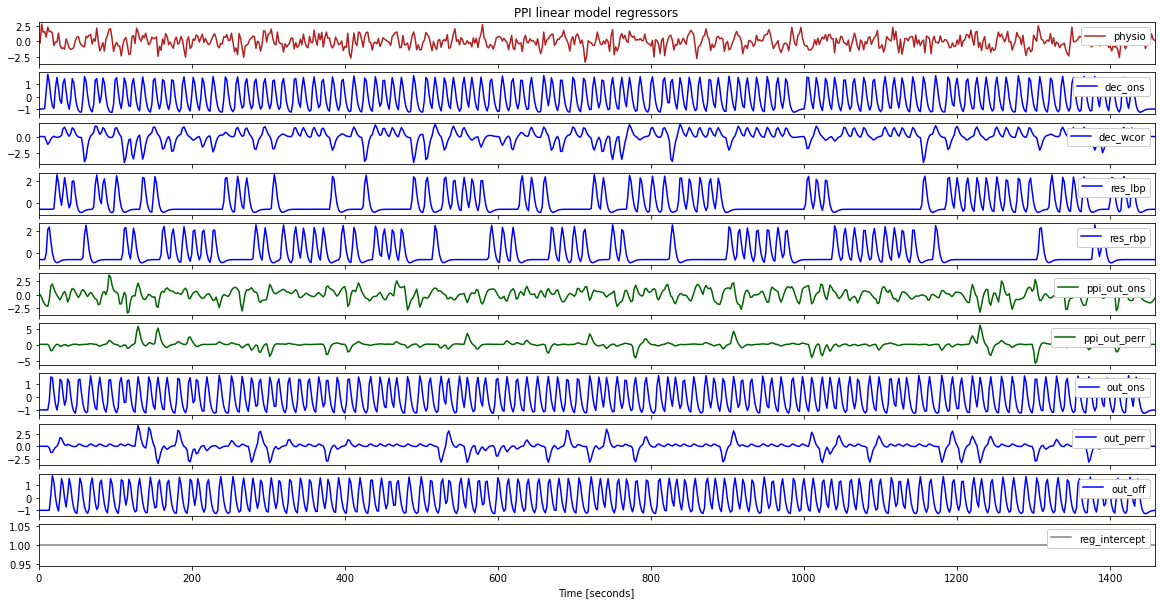

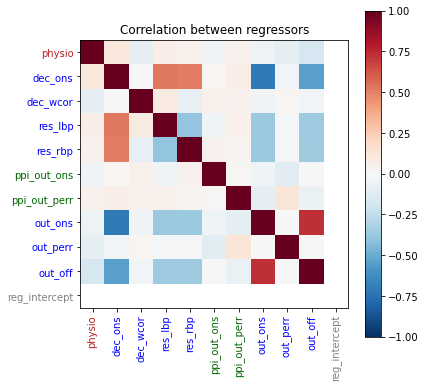

In [10]:
beta_types = ['physio', 'psycho', 'psycho', 'psycho', 'psycho', 'ppi', 'ppi', 
             'psycho', 'psycho', 'psycho', 'other']
beta_colors = {'physio': 'firebrick', 'psycho': 'blue', 
               'ppi': 'darkgreen', 'other': 'gray'}

Xfiltered = Xstd[beta_names]

# Plot 1: Example regressors
fig, axs = plt.subplots(
    nrows=Xfiltered.shape[1], 
    sharex=True, 
    figsize=(20, 10), 
    facecolor='w')

for i, (column, beta_type) in enumerate(zip(Xfiltered, beta_types)):
    axs[i].plot(frame_times, Xfiltered[column], 
                color=beta_colors[beta_type], label=column)
    axs[i].legend(loc='upper right', framealpha=1)
    axs[i].set_xlim([0, max(frame_times)])
    
axs[0].set_title('PPI linear model regressors')
axs[-1].set_xlabel('Time [seconds]')

# Plot 2: Correlation between regressors
fig, ax = plt.subplots(figsize=(6, 6), facecolor='w')
plt.imshow(Xfiltered.corr(), cmap='RdBu_r', clim=[-1, 1])

plt.colorbar()
plt.yticks(range(Xfiltered.shape[1]), Xfiltered.columns)
plt.xticks(range(Xfiltered.shape[1]), Xfiltered.columns, rotation=90)
plt.title('Correlation between regressors')

tickcolors = (beta_colors[beta_type] for beta_type in beta_types)
for xticklabel, yticklabel, tickcolor in zip(plt.gca().get_xticklabels(), 
                                             plt.gca().get_yticklabels(), 
                                             tickcolors):
    xticklabel.set_color(tickcolor)
    yticklabel.set_color(tickcolor)

plt.show()